In [27]:
import pandas as pd
from top2vec import Top2Vec
import top2vec
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import umap

In [2]:
# 1. load the data

df = pd.read_csv("../data/sample_100k_v2.csv")
documents = df["Description"].dropna().astype(str).tolist()

In [6]:
print(len(documents))

99968


In [3]:
# 2. Using Top2Vec Model to show the number of topic
model = Top2Vec(documents, embedding_model='doc2vec', 
                speed='learn', workers=4, min_count=300)
print(f"Number of topics found: {model.get_num_topics()}")


2025-05-13 00:48:17,240 - top2vec - INFO - Pre-processing documents for training
2025-05-13 00:48:34,486 - top2vec - INFO - Creating joint document/word embedding
2025-05-13 00:55:37,296 - top2vec - INFO - Creating lower dimension embedding of documents
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-13 00:57:13,889 - top2vec - INFO - Finding dense areas of documents
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-13 00:57:23,212 - top2vec - INFO

Number of topics found: 501


In [33]:
def get_reduced_topic_keywords(model, num_topics):
    """
    Aggregate representative keywords for reduced topics using Top2Vec's hierarchical_topic_reduction.

    Parameters:
        model (Top2Vec): A trained Top2Vec model.
        num_topics (int): The target number of reduced topics.

    Returns:
        dict: A dictionary where keys are reduced topic indices, and values are lists of aggregated keywords.
    """
    # Perform hierarchical topic reduction
    hierarchy = model.hierarchical_topic_reduction(num_topics=num_topics)

    # Get original topic keywords (words per topic)
    original_topic_words, _ = model.get_topics()

    reduced_topic_keywords = {}

    # For each reduced topic, merge the keywords from its constituent original topics
    for new_topic_id, original_topic_ids in enumerate(hierarchy):
        words = []
        for topic_id in original_topic_ids:
            words.extend(original_topic_words[topic_id])  # collect words from each original topic

        # Optionally: remove duplicates and select top frequent words
        from collections import Counter
        most_common_words = [word for word, _ in Counter(words).most_common(10)]

        reduced_topic_keywords[new_topic_id] = most_common_words

    return reduced_topic_keywords

In [34]:
# Reduce topics to 100 and retrieve representative keywords
reduced_keywords = get_reduced_topic_keywords(model, num_topics=100)

# Print reduced topics and their keywords
for topic_id, keywords in reduced_keywords.items():
    print(f"Reduced Topic {topic_id}: {', '.join(keywords)}")

Reducing topics: 100%|███████████████████████████████████████████████████████████████| 401/401 [05:44<00:00,  1.16it/s]


ValueError: too many values to unpack (expected 2)

In [21]:
topic_sizes, topic_nums = model.get_topic_sizes()

top_n = 10
sorted_idx = np.argsort(topic_sizes)[::-1]
top_topic_nums = [topic_nums[i] for i in sorted_idx[:top_n]]

topics_words, word_scores, topic_ids = model.get_topics()

# Print 10 most popular topics
for i in range(len(topic_ids)):
    if topic_ids[i] in top_topic_nums:
        print(f"\n🔥 Topic #{topic_ids[i]} ({topic_sizes[topic_nums.tolist().index(topic_ids[i])]} docs)")
        for word, score in zip(topics_words[i][:10], word_scores[i][:10]):
            print(f"  {word:15s}  (score: {score:.4f})")


🔥 Topic #0 (4368 docs)
  shipping         (score: 0.5288)
  faster           (score: 0.5267)
  better           (score: 0.4862)
  service          (score: 0.4752)
  fpo              (score: 0.2392)
  customer         (score: 0.1959)
  multiple         (score: 0.1903)
  depending        (score: 0.1687)
  orders           (score: 0.1621)
  satisfaction     (score: 0.1619)

🔥 Topic #1 (3777 docs)
  murder           (score: 0.5792)
  her              (score: 0.5630)
  she              (score: 0.5576)
  finds            (score: 0.5457)
  herself          (score: 0.5404)
  him              (score: 0.5384)
  dangerous        (score: 0.5363)
  killer           (score: 0.5348)
  mysterious       (score: 0.5301)
  seems            (score: 0.5210)

🔥 Topic #2 (2572 docs)
  smartbuyglasses  (score: 0.8392)
  curve            (score: 0.8387)
  harmful          (score: 0.8337)
  shield           (score: 0.8334)
  staying          (score: 0.8301)
  rays             (score: 0.8278)
  frames          

C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


get_documents_topics返回了4个值


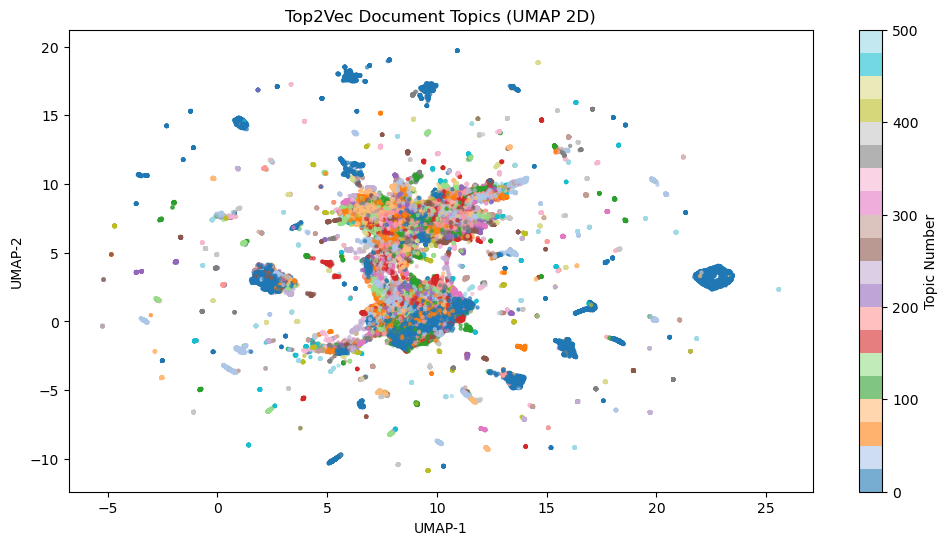

In [31]:
# 1. UMAP 降维
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
vectors_2d = reducer.fit_transform(model.document_vectors)

# 2. 获取文档主题标签
doc_ids = list(range(len(model.documents)))
# 检查get_documents_topics返回的实际值数量
result = model.get_documents_topics(doc_ids=doc_ids)
# 根据实际返回值数量进行解包
if len(result) == 2:
    topics, scores = result
elif len(result) == 3:
    topics, scores, _ = result  # 假设第三个值不需要
    # 或者：topics, scores, something_else = result  # 如果需要第三个值
else:
    # 输出返回的值以便检查
    print(f"get_documents_topics返回了{len(result)}个值")
    # 手动分配我们需要的值
    topics = result[0]  # 假设第一个是主题
    scores = result[1]  # 假设第二个是分数

# 3. 可视化
plt.figure(figsize=(12, 6))
scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=topics, cmap="tab20", s=5, alpha=0.6)
plt.colorbar(scatter, label="Topic Number")
plt.title("Top2Vec Document Topics (UMAP 2D)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


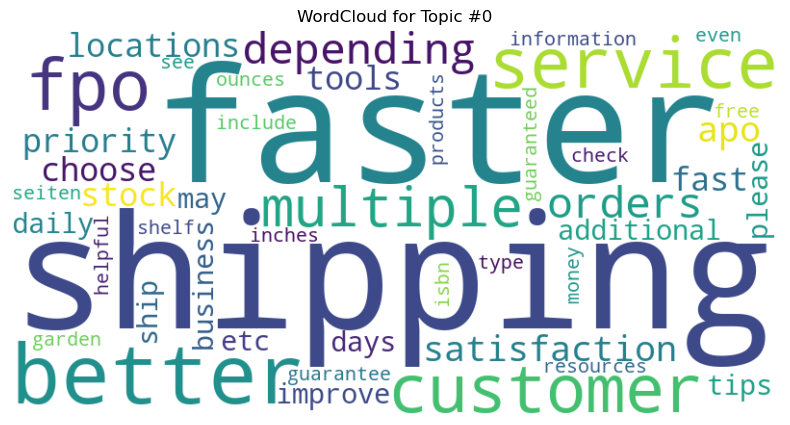

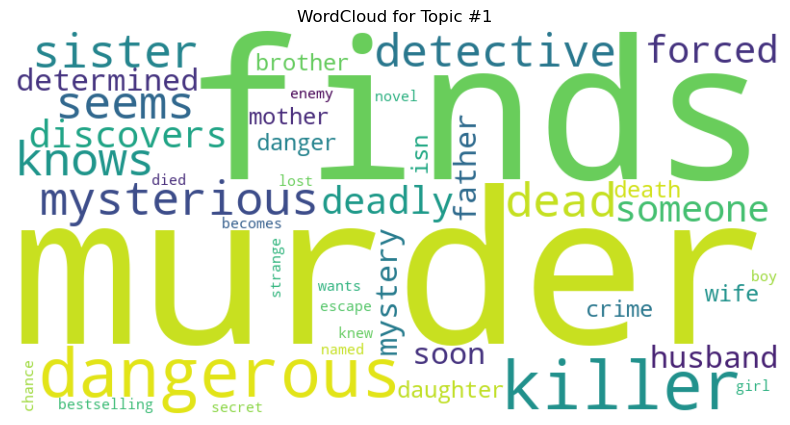

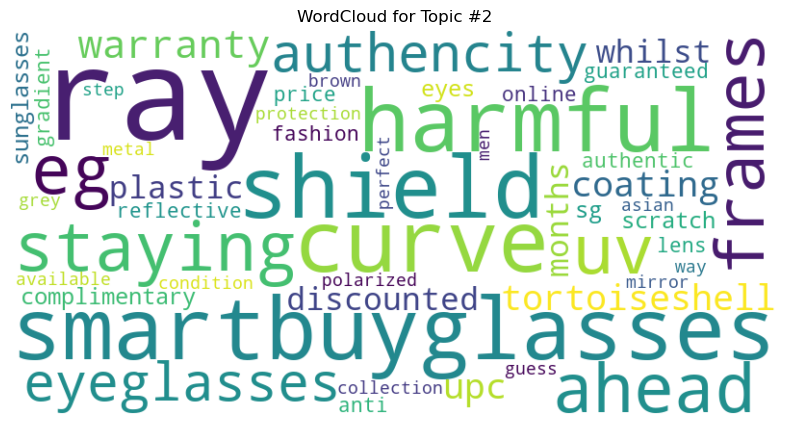

In [24]:
topics_words, _, topic_nums = model.get_topics()

for i in range(3):  
    text = " ".join(topics_words[i])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Topic #{topic_nums[i]}")
    plt.show()

In [6]:
print(f"Top2Vec version: {top2vec.__version__}")

Top2Vec version: 1.0.36


In [20]:
# See what get_topics() actually returns
topics_result = model.get_topics()
print(f"Type of get_topics() result: {type(topics_result)}")
if isinstance(topics_result, dict) or isinstance(topics_result, list):
    print(f"Length of result: {len(topics_result)}")
    if len(topics_result) > 0:
        print(f"Sample of first element: {topics_result[0] if isinstance(topics_result, list) else next(iter(topics_result.values()))}")

Type of get_topics() result: <class 'tuple'>


In [9]:
# 4. Show the topic
topic_words, word_scores, topic_nums = model.get_topics()

for i, topic_num in enumerate(topic_nums):
    print(f"\nTopic #{topic_num}: {topic_words[i][:10]}")  


Topic #0: ['shipping' 'faster' 'better' 'service' 'fpo' 'customer' 'multiple'
 'depending' 'orders' 'satisfaction']

Topic #1: ['murder' 'her' 'she' 'finds' 'herself' 'him' 'dangerous' 'killer'
 'mysterious' 'seems']

Topic #2: ['smartbuyglasses' 'curve' 'harmful' 'shield' 'staying' 'rays' 'frames'
 'ahead' 'uv' 'eg']

Topic #3: ['tumble' 'bleach' 'fastenings' 'sleeves' 'knitted' 'solid' 'dry'
 'multipockets' 'appliques' 'breasted']

Topic #4: ['cleated' 'toeline' 'origin' 'textile' 'parts' 'leather' 'sole' 'animal'
 'round' 'square']

Topic #5: ['war' 'political' 'government' 'britain' 'nation' 'germany' 'politics'
 'economic' 'historians' 'nineteenth']

Topic #6: ['god' 'scripture' 'biblical' 'christ' 'christians' 'christian' 'jesus'
 'prayer' 'spiritual' 'church']

Topic #7: ['multipockets' 'bleach' 'tumble' 'waisted' 'fastenings' 'tapered'
 'regular' 'solid' 'fastening' 'appliques']

Topic #8: ['philosophical' 'philosophy' 'intellectual' 'writings' 'ethics'
 'religious' 'theology'

In [ ]:

# 5. 你也可以为每条记录获取最相近的主题编号
topic_nums, topic_scores, topic_words = model.get_documents_topics(documents)

# 加回 DataFrame 进行分析
df["top2vec_topic"] = topic_nums
